<a href="https://colab.research.google.com/github/Lilchoto3/DS-Unit-2-Linear-Models/blob/master/module3-ridge-regression/LS_DS_213_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 3*

---

# Ridge Regression

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

- [ ] Use a subset of the data where `BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'` and the sale price was more than 100 thousand and less than 2 million.
- [ ] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [ ] Do one-hot encoding of categorical features.
- [ ] Do feature selection with `SelectKBest`.
- [ ] Fit a ridge regression model with multiple features. Use the `normalize=True` parameter (or do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html) beforehand — use the scaler's `fit_transform` method with the train set, and the scaler's `transform` method with the test set)
- [ ] Get mean absolute error for the test set.
- [ ] As always, commit your notebook to your fork of the GitHub repo.

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


## Stretch Goals

Don't worry, you aren't expected to do all these stretch goals! These are just ideas to consider and choose from.

- [ ] Add your own stretch goal(s) !
- [ ] Instead of `Ridge`, try `LinearRegression`. Depending on how many features you select, your errors will probably blow up! 💥
- [ ] Instead of `Ridge`, try [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
import pandas as pd
import numpy as np
import pandas_profiling

# Read New York City property sales data
df = pd.read_csv(DATA_PATH+'condos/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

In [0]:
# BOROUGH is a numeric column, but arguably should be a categorical feature,
# so convert it from a number to a string
df['BOROUGH'] = df['BOROUGH'].astype(str)

In [0]:
# Reduce cardinality for NEIGHBORHOOD feature

# Get a list of the top 10 neighborhoods
top10 = df['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10, 
# replace the neighborhood with 'OTHER'
df.loc[~df['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'

In [53]:
# MY CODE STARTS HERE

# Get the subset of data as requested by the assignment
df = df[df['BUILDING_CLASS_CATEGORY'].str.startswith('01 ONE FAMILY DWELLINGS')]
df = df[((df['SALE_PRICE']>100000) & (df['SALE_PRICE']<2000000))]

print(df.shape)
print(df.isnull().sum())
print(df.dtypes)
df.head()

(3151, 21)
BOROUGH                              0
NEIGHBORHOOD                         0
BUILDING_CLASS_CATEGORY              0
TAX_CLASS_AT_PRESENT                 0
BLOCK                                0
LOT                                  0
EASE-MENT                         3151
BUILDING_CLASS_AT_PRESENT            0
ADDRESS                              0
APARTMENT_NUMBER                  3150
ZIP_CODE                             0
RESIDENTIAL_UNITS                    0
COMMERCIAL_UNITS                     0
TOTAL_UNITS                          0
LAND_SQUARE_FEET                     0
GROSS_SQUARE_FEET                    0
YEAR_BUILT                           0
TAX_CLASS_AT_TIME_OF_SALE            0
BUILDING_CLASS_AT_TIME_OF_SALE       0
SALE_PRICE                           0
SALE_DATE                            0
dtype: int64
BOROUGH                            object
NEIGHBORHOOD                       object
BUILDING_CLASS_CATEGORY            object
TAX_CLASS_AT_PRESENT           

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
44,3,OTHER,01 ONE FAMILY DWELLINGS,1,5495,801,NaN,A9,4832 BAY PARKWAY,NaN,11230.0,1.0,0.0,1.0,"6,800",1325.0,1930.0,1,A9,550000,01/01/2019
61,4,OTHER,01 ONE FAMILY DWELLINGS,1,7918,72,NaN,A1,80-23 232ND STREET,NaN,11427.0,1.0,0.0,1.0,"4,000",2001.0,1940.0,1,A1,200000,01/01/2019
78,2,OTHER,01 ONE FAMILY DWELLINGS,1,4210,19,NaN,A1,1260 RHINELANDER AVE,NaN,10461.0,1.0,0.0,1.0,"3,500",2043.0,1925.0,1,A1,810000,01/02/2019
108,3,OTHER,01 ONE FAMILY DWELLINGS,1,5212,69,NaN,A1,469 E 25TH ST,NaN,11226.0,1.0,0.0,1.0,"4,000",2680.0,1899.0,1,A1,125000,01/02/2019
111,3,OTHER,01 ONE FAMILY DWELLINGS,1,7930,121,NaN,A5,5521 WHITTY LANE,NaN,11203.0,1.0,0.0,1.0,"1,710",1872.0,1940.0,1,A5,620000,01/02/2019


In [0]:
# Extra cleanup
# Drop dataless columns
df = df.drop(['EASE-MENT', 'APARTMENT_NUMBER'], axis=1)

# make LAND_SQUARE_FEET into integers
df['LAND_SQUARE_FEET'] = pd.to_numeric(df['LAND_SQUARE_FEET'].str.replace(',',''))

In [55]:
# Set up the train/test split

# Start by converting the sale date to a datetime format to be able to compare it easier
df['SALE_DATE'] = pd.to_datetime(df['SALE_DATE'], infer_datetime_format=True)
print(df['SALE_DATE'].dtype)
df.head(1)

datetime64[ns]


,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT,ADDRESS,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
44,3,OTHER,01 ONE FAMILY DWELLINGS,1,5495,801,A9,4832 BAY PARKWAY,11230.0,1.0,0.0,1.0,6800,1325.0,1930.0,1,A9,550000,2019-01-01


In [56]:
# Split the data
train = df[df['SALE_DATE']<pd.to_datetime('2019-04-01')]
test = df[df['SALE_DATE']>=pd.to_datetime('2019-04-01')]

# Check that i've seperated it correctly
print(train['SALE_DATE'].dt.month.value_counts(),'\n')
print(test['SALE_DATE'].dt.month.value_counts())

1    947
3    799
2    761
Name: SALE_DATE, dtype: int64 

4    644
Name: SALE_DATE, dtype: int64


In [57]:
# Looks good, now for one-hot encoding

# Lets see which columns are good for that sort of thing
train.describe(include='object')

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,BUILDING_CLASS_AT_TIME_OF_SALE
count,2507,2507,2507,2507,2507,2507,2507
unique,5,6,1,2,13,2497,11
top,4,OTHER,01 ONE FAMILY DWELLINGS,1,A1,125-27 LUCAS STREET,A1
freq,1204,2382,2507,2476,919,2,919


In [0]:
# set up features and target
target = 'SALE_PRICE'
high_cardinality = ['BUILDING_CLASS_CATEGORY','BUILDING_CLASS_AT_PRESENT','ADDRESS','BUILDING_CLASS_AT_TIME_OF_SALE','SALE_DATE']
features = train.columns.drop([target] + high_cardinality)

# Set up matrixes
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

# encode X_train
import category_encoders as ce
encoder = ce.OneHotEncoder(use_cat_names=True)
X_train = encoder.fit_transform(X_train)

In [59]:
X_train.head(5)

,BOROUGH_3,BOROUGH_4,BOROUGH_2,BOROUGH_5,BOROUGH_1,NEIGHBORHOOD_OTHER,NEIGHBORHOOD_FLUSHING-NORTH,NEIGHBORHOOD_BEDFORD STUYVESANT,NEIGHBORHOOD_FOREST HILLS,NEIGHBORHOOD_BOROUGH PARK,NEIGHBORHOOD_ASTORIA,TAX_CLASS_AT_PRESENT_1,TAX_CLASS_AT_PRESENT_1D,BLOCK,LOT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE
44,1,0,0,0,0,1,0,0,0,0,0,1,0,5495,801,11230.0,1.0,0.0,1.0,6800,1325.0,1930.0,1
61,0,1,0,0,0,1,0,0,0,0,0,1,0,7918,72,11427.0,1.0,0.0,1.0,4000,2001.0,1940.0,1
78,0,0,1,0,0,1,0,0,0,0,0,1,0,4210,19,10461.0,1.0,0.0,1.0,3500,2043.0,1925.0,1
108,1,0,0,0,0,1,0,0,0,0,0,1,0,5212,69,11226.0,1.0,0.0,1.0,4000,2680.0,1899.0,1
111,1,0,0,0,0,1,0,0,0,0,0,1,0,7930,121,11203.0,1.0,0.0,1.0,1710,1872.0,1940.0,1


In [60]:
# encode X_test
X_test = encoder.transform(X_test)

X_test.head()

,BOROUGH_3,BOROUGH_4,BOROUGH_2,BOROUGH_5,BOROUGH_1,NEIGHBORHOOD_OTHER,NEIGHBORHOOD_FLUSHING-NORTH,NEIGHBORHOOD_BEDFORD STUYVESANT,NEIGHBORHOOD_FOREST HILLS,NEIGHBORHOOD_BOROUGH PARK,NEIGHBORHOOD_ASTORIA,TAX_CLASS_AT_PRESENT_1,TAX_CLASS_AT_PRESENT_1D,BLOCK,LOT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE
18235,0,0,1,0,0,1,0,0,0,0,0,1,0,5913,878,10471.0,1.0,0.0,1.0,5000,2272.0,1930.0,1
18239,0,0,1,0,0,1,0,0,0,0,0,1,0,5488,48,10465.0,1.0,0.0,1.0,2500,720.0,1935.0,1
18244,1,0,0,0,0,1,0,0,0,0,0,1,0,5936,31,11209.0,1.0,0.0,1.0,2880,2210.0,1925.0,1
18280,1,0,0,0,0,1,0,0,0,0,0,1,0,7813,24,11210.0,1.0,0.0,1.0,1305,1520.0,1915.0,1
18285,1,0,0,0,0,1,0,0,0,0,0,1,0,8831,160,11229.0,1.0,0.0,1.0,1800,840.0,1925.0,1


In [61]:
print(X_train.shape, X_test.shape)

(2507, 23) (644, 23)


In [0]:
# Use SelectKBest to get the best features
from sklearn.feature_selection import SelectKBest, f_regression

selector = SelectKBest(score_func=f_regression, k=15)

# select features
X_train_selected = selector.fit_transform(X_train, y_train)

# Squelch annoying warnings
import warnings
warnings.simplefilter('ignore')

In [63]:
# what got picked?
selected_mask = selector.get_support()
all_names = X_train.columns
selected_names = all_names[selected_mask]
unselected_names = all_names[~selected_mask]

print('Selected Features:')
for x in selected_names:
  print(x)

print('\nUnselected Features:')
for x in unselected_names:
  print(x)

Selected Features:
BOROUGH_3
BOROUGH_2
BOROUGH_5
NEIGHBORHOOD_OTHER
NEIGHBORHOOD_FLUSHING-NORTH
NEIGHBORHOOD_FOREST HILLS
NEIGHBORHOOD_BOROUGH PARK
BLOCK
ZIP_CODE
COMMERCIAL_UNITS
TOTAL_UNITS
LAND_SQUARE_FEET
GROSS_SQUARE_FEET

Unselected Features:
BOROUGH_4
BOROUGH_1
NEIGHBORHOOD_BEDFORD STUYVESANT
NEIGHBORHOOD_ASTORIA
TAX_CLASS_AT_PRESENT_1
TAX_CLASS_AT_PRESENT_1D
LOT
RESIDENTIAL_UNITS
YEAR_BUILT
TAX_CLASS_AT_TIME_OF_SALE


In [68]:
# now to check the mean absolute errors for each number of features
# to see which number of features is the best

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

for k in range(1, len(X_train.columns)+1):
  print(f'{k} Features Used:')

  # select the best features
  selector = SelectKBest(score_func=f_regression, k=k)
  X_train_selected = selector.fit_transform(X_train, y_train)
  X_test_selected = selector.transform(X_test)

  # set up the model and get MAE
  model = LinearRegression()
  model.fit(X_train_selected, y_train)
  y_pred = model.predict(X_test_selected)
  mae = mean_absolute_error(y_test, y_pred)
  print(f'Test Mean Absolute Error: ${mae:,.0f} \n')

1 Features Used:
Test Mean Absolute Error: $183,641 

2 Features Used:
Test Mean Absolute Error: $179,555 

3 Features Used:
Test Mean Absolute Error: $170,782 

4 Features Used:
Test Mean Absolute Error: $169,937 

5 Features Used:
Test Mean Absolute Error: $168,235 

6 Features Used:
Test Mean Absolute Error: $168,339 

7 Features Used:
Test Mean Absolute Error: $167,966 

8 Features Used:
Test Mean Absolute Error: $165,030 

9 Features Used:
Test Mean Absolute Error: $165,654 

10 Features Used:
Test Mean Absolute Error: $165,077 

11 Features Used:
Test Mean Absolute Error: $155,288 

12 Features Used:
Test Mean Absolute Error: $156,684 

13 Features Used:
Test Mean Absolute Error: $154,811 

14 Features Used:
Test Mean Absolute Error: $154,835 

15 Features Used:
Test Mean Absolute Error: $154,835 

16 Features Used:
Test Mean Absolute Error: $154,588 

17 Features Used:
Test Mean Absolute Error: $154,482 

18 Features Used:
Test Mean Absolute Error: $155,279 

19 Features Used:
T

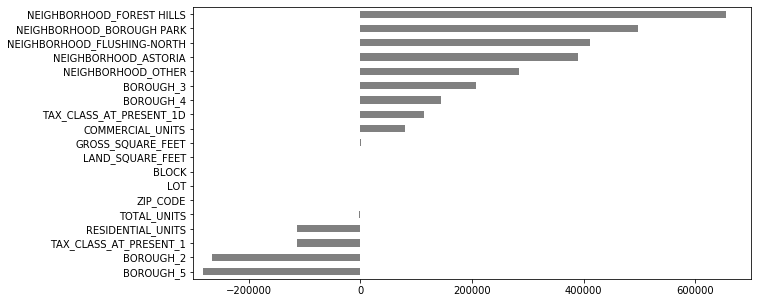

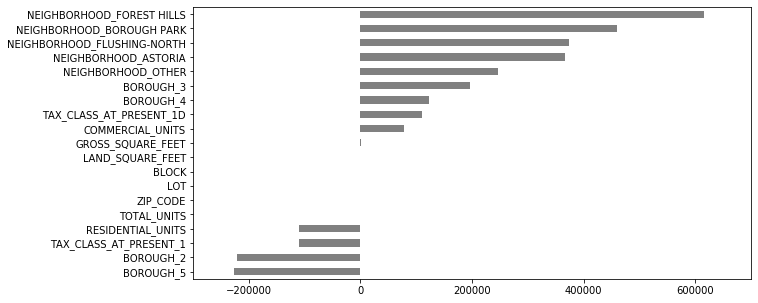

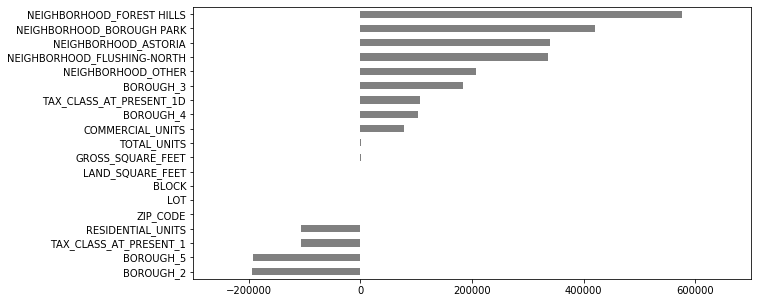

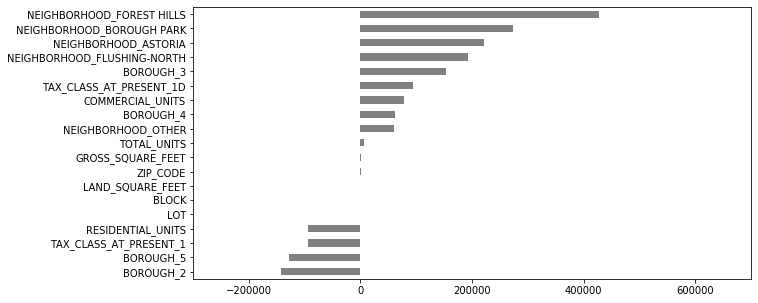

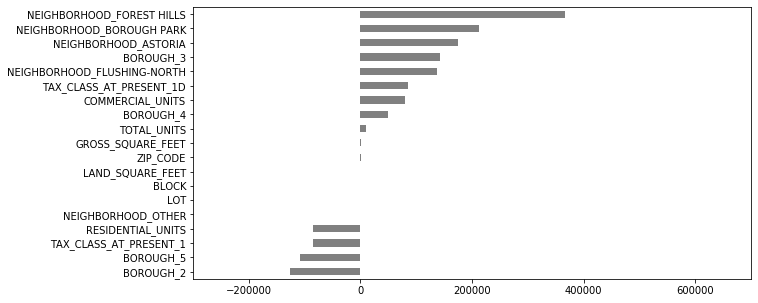

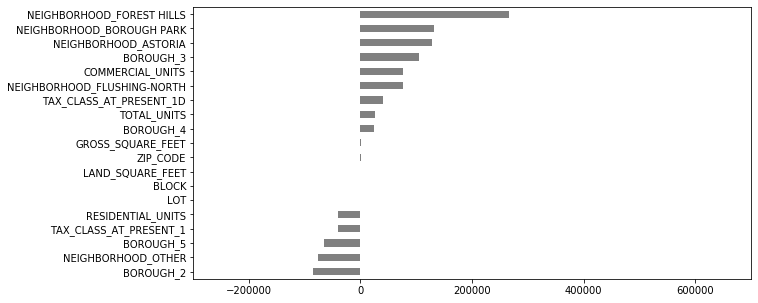

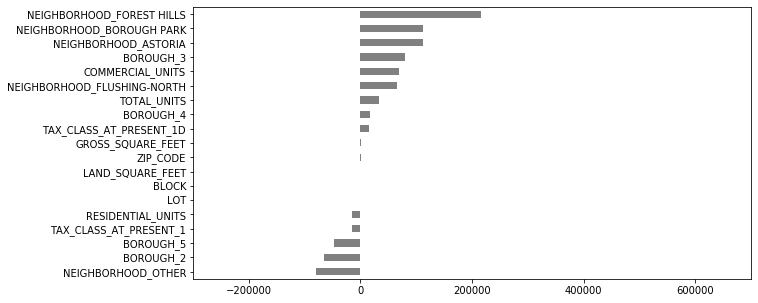

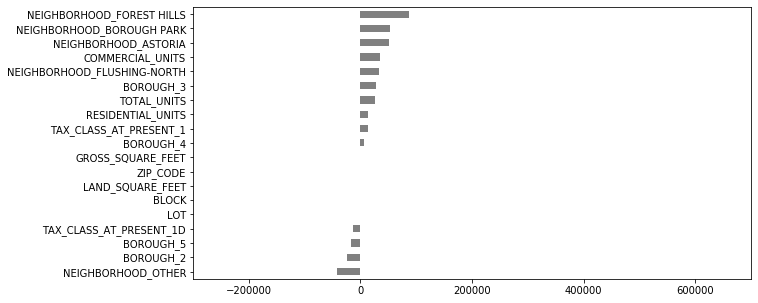

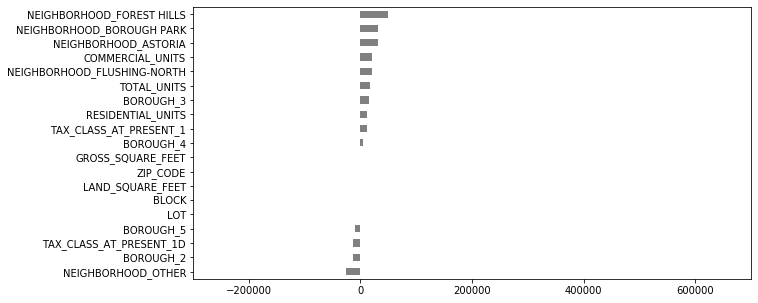

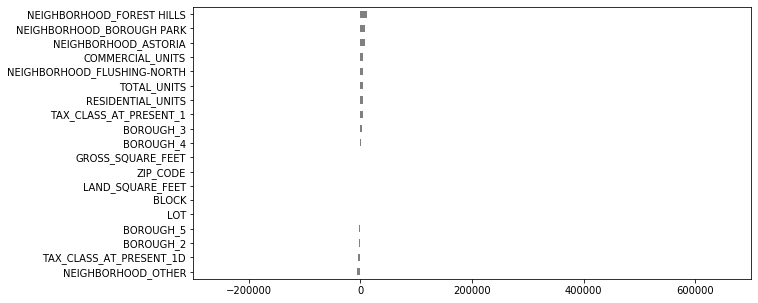

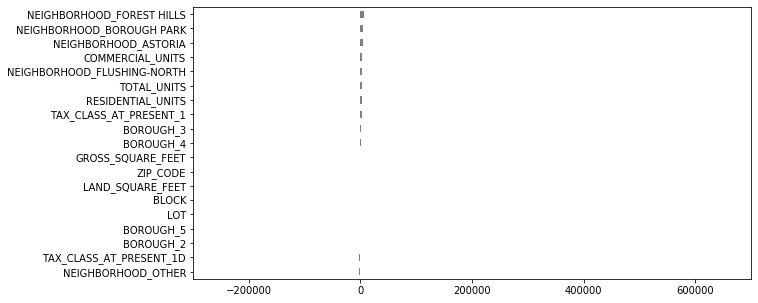

In [79]:
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from IPython.display import display, HTML
%matplotlib inline

# So it looks like 19 features has the best MAE
# now to see which alpha has the best MAE for Ridge Regressions
# I'm gonna do a logarithmic thing from .001 to 100

# Get a dataframe with 19 selected features
selector = SelectKBest(score_func=f_regression, k=19)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

for alpha in [.001, .005, .01, .05, .1, .5, 1, 5, 10, 50, 100]:
  display(HTML(f'Ridge Regression with alpha: {alpha}'))
  model = Ridge(alpha=alpha, normalize=True)
  model.fit(X_train_selected, y_train)
  y_pred = model.predict(X_test_selected)

  # Get test MAE
  mae = mean_absolute_error(y_test, y_pred)
  display(HTML(f'Test Mean Absolute Error: ${mae:,.0f}'))

  # Plot coefficients
  coefs = pd.Series(model.coef_, X_train.columns[selector.get_support()])
  plt.figure(figsize=(10,5))
  coefs.sort_values().plot.barh(color='grey')
  plt.xlim(-300000,700000)
  plt.show()

In [0]:
# So, in this case, analyzing the data using 19 features with
# a Ridge regression with alpha = 0.05 would give the best
# Mean Absolute Error of $154,927